<a href="https://colab.research.google.com/github/ganesh3/pytorch-work/blob/master/pytorch_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is made from [Learn Pytorch](https://www.learnpytorch.io/02_pytorch_classification/) site for the purpose of learning and is essentially a copy.

In [1]:
import torch
from torch import nn

In [2]:
from sklearn.datasets import make_circles

In [3]:
n_sample = 1000

X, y = make_circles(n_sample, noise = 0.03, random_state=42)

In [4]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

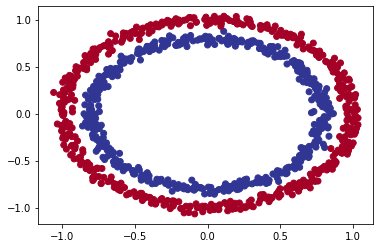

In [7]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y = X[:, 1], c=y, cmap=plt.cm.RdYlBu )

In [8]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [12]:
# check & assign device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
  """
  layer1 : Input 2 features i.e. X[:, 0], X[:, 1] and create 5 neurons in the hidden layers
  layer2: Hidden layer to output layer mapping which will map from 5 neurons to 1 neuron as we are doing binary classification
  """
  def __init__(self):
    super().__init__()
    # takes in 2 features (X), produces 5 features
    self.layer1 = nn.Linear(in_features=2, out_features=5)
    # takes in 5 features, produces 1 feature (y)
    self.layer2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer2(self.layer1(x))

In [14]:
# 2. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
# You can also do the same as above using nn.Sequential.
# nn.Sequential performs a forward pass computation of the input data through the layers in the order they appear.
# nn.Sequential is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.
# So if you'd something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.
model_v0_seq = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_v0_seq

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))

In [17]:
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.2652],
        [-0.3448],
        [-0.0488],
        [-0.3266],
        [-0.0361],
        [-0.0848],
        [-0.3188],
        [-0.2578],
        [-0.0496],
        [-0.3500]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [18]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
# The documentation (https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) for torch.nn.BCEWithLogitsLoss() states that 
# it's more numerically stable than using torch.nn.BCELoss() after a nn.Sigmoid layer.
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), lr= 0.1)

In [19]:
# Calculate accuracy (a classification metric)
def accuracy(y_true, y_pred):
  # torch.eq() calculates where two tensors are equal
  #print(f"Checking if two tensors are equal : {torch.eq(y_true, y_pred)}")
  #print(f"Checking the sume of equal tensors : {torch.eq(y_true, y_pred).sum()}")
  correct = torch.eq(y_true, y_pred).sum().item()
  # changed to y_true from y_pred in the learn pytorch article to check if there is any difference between the 2 tensors. Ideally, you will check it with y_pred
  acc = (correct/len(y_pred)) * 100
  return acc

In [20]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[-0.2652],
        [-0.3448],
        [-0.0488],
        [-0.3266],
        [-0.0361]], grad_fn=<SliceBackward0>)

In [21]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.4341],
        [0.4147],
        [0.4878],
        [0.4191],
        [0.4910]], grad_fn=<SliceBackward0>)

In [22]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

In [23]:
# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

In [24]:
print(torch.eq(y_preds[:5].squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True])


In [25]:
y_preds.shape

torch.Size([200, 1])

In [26]:
# Get rid of extra dimension
y_preds[:5].squeeze()

tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [28]:
# the loop is similar to one covered in pytorch worflow and hence majorly no commnents covered
torch.manual_seed(42)

num_epochs = 100

for epoch in range(num_epochs):
  #move data to device where the model is running else the code wil fail
  X_train, y_train = X_train.to(device), y_train.to(device)
  X_test, y_test = X_test.to(device), y_test.to(device)

  model_0.train()
  # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))
  # Using nn.BCEWithLogitsLoss works with raw logits
  train_loss = loss_fn(y_logits, y_train)
  train_acc = accuracy(y_true=y_train, y_pred=y_preds)

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_0.eval()

  with torch.inference_mode():
    y_test_logits = model_0(X_test).squeeze()
    y_test_preds = torch.round(torch.sigmoid(y_test_logits))

    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy(y_test, y_test_preds)

  if epoch % 10 == 0:
    print(f"Epoch is {epoch}, train loss is {train_loss:.5f}, Train accuracy is {train_acc:.2f}%, test loss is {test_loss:.5f}, and Test accuracy is {test_acc:.2f}%") 

Epoch is 0, train loss is 0.69938, Train accuracy is 44.00%, test loss is 0.69373, and Test accuracy is 46.50%
Epoch is 10, train loss is 0.69588, Train accuracy is 46.88%, test loss is 0.69171, and Test accuracy is 50.50%
Epoch is 20, train loss is 0.69457, Train accuracy is 47.75%, test loss is 0.69143, and Test accuracy is 53.00%
Epoch is 30, train loss is 0.69400, Train accuracy is 48.12%, test loss is 0.69164, and Test accuracy is 53.50%
Epoch is 40, train loss is 0.69370, Train accuracy is 48.75%, test loss is 0.69194, and Test accuracy is 53.00%
Epoch is 50, train loss is 0.69350, Train accuracy is 49.38%, test loss is 0.69225, and Test accuracy is 53.50%
Epoch is 60, train loss is 0.69337, Train accuracy is 50.00%, test loss is 0.69252, and Test accuracy is 53.00%
Epoch is 70, train loss is 0.69328, Train accuracy is 51.38%, test loss is 0.69277, and Test accuracy is 52.50%
Epoch is 80, train loss is 0.69321, Train accuracy is 53.12%, test loss is 0.69299, and Test accuracy is 

In [29]:
# "Visualize, visualize, visualize!"
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


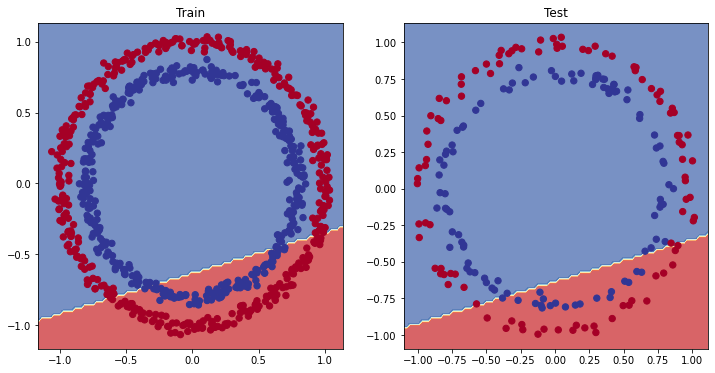

In [30]:
# Since our data is circular, drawing a straight line can at best cut it down the middle.
# In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [31]:
# Let's see what happens if we add an extra layer to our model, fit for longer (epochs=1000 instead of epochs=100) and increase the number of hidden units from 5 to 10.
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

In [32]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# Does not require sigmoid on input
loss_fn = nn.BCEWithLogitsLoss()
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr = 0.1)

In [34]:
X_test.shape, y_test.shape

(torch.Size([200, 2]), torch.Size([200]))

In [35]:
torch.manual_seed(42)

num_epoch = 1000

for epoch in range(num_epoch):
  # Put data to target device
  X_train, y_train = X_train.to(device), y_train.to(device)
  X_test, y_test = X_test.to(device), y_test.to(device)

  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy(y_train, y_pred)

  optimizer_1.zero_grad()
  loss.backward()
  optimizer_1.step()

  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    y_test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    acc = accuracy(y_test, y_test_preds)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 51.00% | Test loss: 0.69261, Test acc: 52.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 48.00% | Test loss: 0.69379, Test acc: 52.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 46.00% | Test loss: 0.69437, Test acc: 52.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 45.00% | Test loss: 0.69458, Test acc: 52.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 46.00% | Test loss: 0.69465, Test acc: 52.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 46.00% | Test loss: 0.69467, Test acc: 52.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 46.00% | Test loss: 0.69468, Test acc: 52.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 46.00% | Test loss: 0.69468, Test acc: 52.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 46.00% | Test loss: 0.69468, Test acc: 52.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 46.00% | Test loss: 0.69468, Test acc: 52.00%


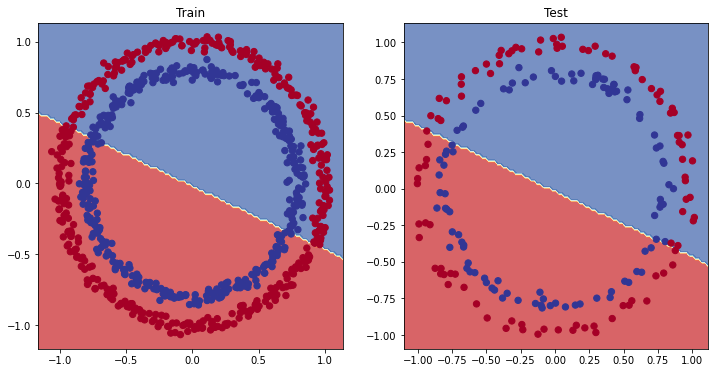

In [36]:
# Our model is still drawing a straight line between the red and blue dots
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Preparing data to see if our model can model a straight line

In [37]:
weights = 0.7
bias = 0.3
start = 0.0
end = 1.0
step = 0.01

# Create data
X_reg = torch.arange(start=start, end=end, step=step).unsqueeze(dim=1)
y_reg = weights * X_reg + bias

len(X_reg)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [38]:
# Create train and test splits
train_split = int(0.8 * len(X_reg))
X_train_reg, y_train_reg = X_reg[:train_split], y_reg[:train_split]
X_test_reg, y_test_reg = X_reg[train_split:], y_reg[train_split:]

len(X_train_reg), len(y_train_reg), len(X_test_reg), len(y_test_reg)

(80, 80, 20, 20)

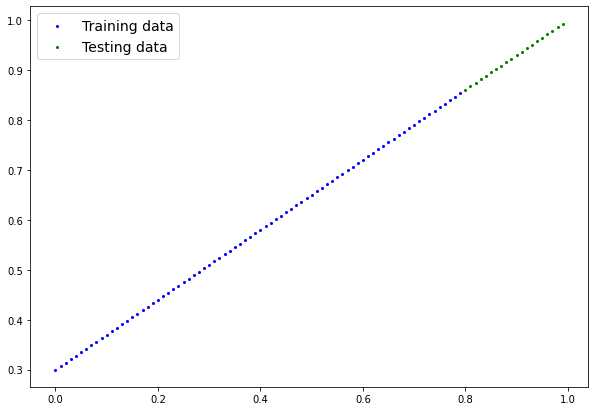

In [39]:
plot_predictions(X_train_reg, y_train_reg, X_test_reg, y_test_reg)

In [40]:
# Adjusting model_1 to fit a straight line
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
# Loss and optimizer
loss_fn_2 = nn.L1Loss()
optimizer_2 = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [42]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_reg)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_reg)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_reg)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_reg)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.70037, Test loss: 0.70427
Epoch: 100 | Train loss: 0.70037, Test loss: 0.70427
Epoch: 200 | Train loss: 0.70037, Test loss: 0.70427
Epoch: 300 | Train loss: 0.70037, Test loss: 0.70427
Epoch: 400 | Train loss: 0.70037, Test loss: 0.70427
Epoch: 500 | Train loss: 0.70037, Test loss: 0.70427
Epoch: 600 | Train loss: 0.70037, Test loss: 0.70427
Epoch: 700 | Train loss: 0.70037, Test loss: 0.70427
Epoch: 800 | Train loss: 0.70037, Test loss: 0.70427
Epoch: 900 | Train loss: 0.70037, Test loss: 0.70427


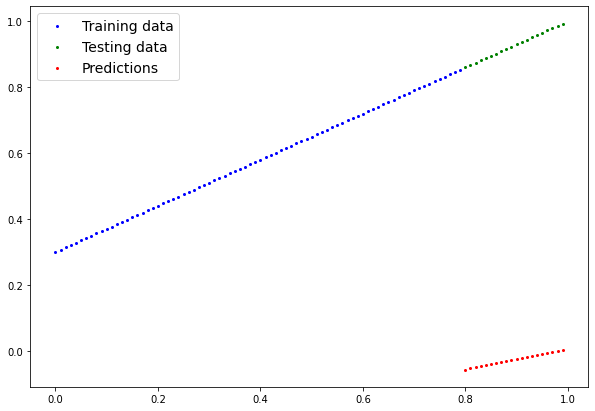

In [43]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_reg)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_reg.cpu(),
                 train_labels=y_train_reg.cpu(),
                 test_data=X_test_reg.cpu(),
                 test_labels=y_test_reg.cpu(),
                 predictions=y_preds.cpu());

The missing piece: non-linearity

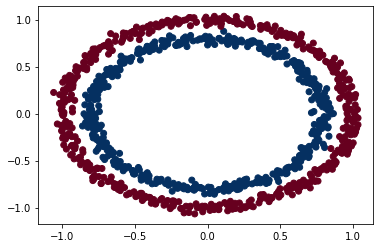

In [44]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [45]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

In [46]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [47]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [48]:
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [49]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [50]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test).squeeze()))

y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

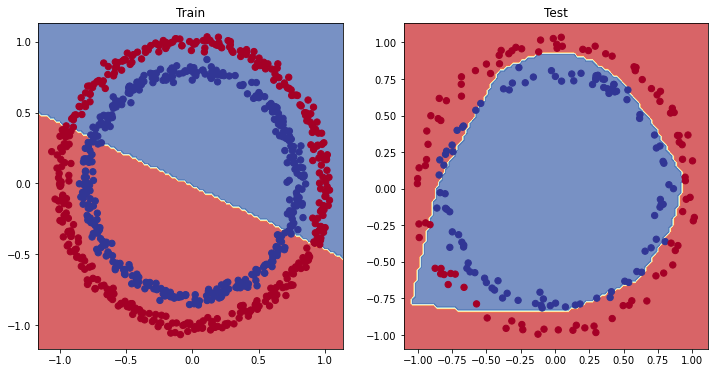

In [51]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

Putting things together by building a multi-class PyTorch model

In [52]:
from sklearn.datasets import make_blobs

In [53]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

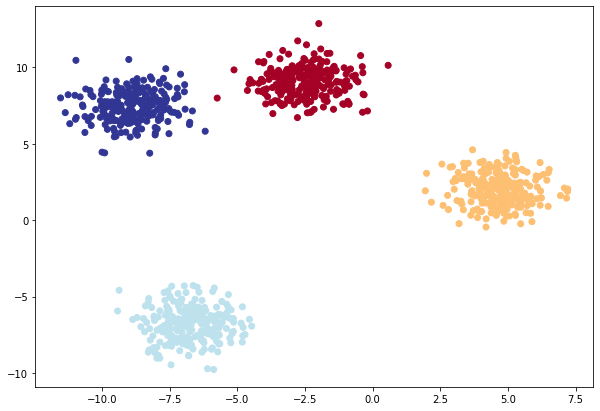

In [54]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, random_state=RANDOM_SEED, centers=NUM_CLASSES)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

Lets create the class for multi class classification

In [58]:
class BlobModel(nn.Module):
  def __init__(self, input_features, out_features, hidden_units=8):
    """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [60]:
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    out_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [62]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer_4 = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [63]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-0.7097, -0.6568, -1.4328, -1.0505],
        [-0.2312, -1.2148, -0.9651, -0.2835],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2471, -0.2418,  0.1720,  0.0051],
        [-0.1523, -1.0461, -0.7691, -0.2185]], grad_fn=<SliceBackward0>)

In [64]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [65]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7189, -0.6782, -1.4654, -1.0904],
        [-0.1043, -0.9593, -0.6114, -0.1405],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4796, -0.5497, -1.0410, -0.7695],
        [-0.2697, -1.2876, -1.0842, -0.3385]], grad_fn=<SliceBackward0>)
tensor([[0.3120, 0.3249, 0.1479, 0.2152],
        [0.3342, 0.1421, 0.2013, 0.3224],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3076, 0.2868, 0.1754, 0.2302],
        [0.3653, 0.1320, 0.1618, 0.3410]], grad_fn=<SliceBackward0>)


In [66]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [68]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))
# You can see the output of torch.argmax() returns 3, so for the features (X) of the sample at index 0, 
# the model is predicting that the most likely class value (y) is 3.

tensor([0.3120, 0.3249, 0.1479, 0.2152], grad_fn=<SelectBackward0>)
tensor(1)


In [69]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.15229, Acc: 38.62% | Test Loss: 1.06802, Test Acc: 44.50%
Epoch: 10 | Loss: 0.62249, Acc: 98.75% | Test Loss: 0.63935, Test Acc: 99.50%
Epoch: 20 | Loss: 0.38991, Acc: 99.75% | Test Loss: 0.39338, Test Acc: 100.00%
Epoch: 30 | Loss: 0.20595, Acc: 99.88% | Test Loss: 0.19858, Test Acc: 100.00%
Epoch: 40 | Loss: 0.07240, Acc: 99.88% | Test Loss: 0.06673, Test Acc: 100.00%
Epoch: 50 | Loss: 0.03496, Acc: 99.88% | Test Loss: 0.03213, Test Acc: 100.00%
Epoch: 60 | Loss: 0.02290, Acc: 99.88% | Test Loss: 0.02061, Test Acc: 100.00%
Epoch: 70 | Loss: 0.01713, Acc: 99.88% | Test Loss: 0.01503, Test Acc: 100.00%
Epoch: 80 | Loss: 0.01376, Acc: 99.88% | Test Loss: 0.01176, Test Acc: 100.00%
Epoch: 90 | Loss: 0.01148, Acc: 99.88% | Test Loss: 0.00959, Test Acc: 100.00%


In [70]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-1.1218,  5.3778, -6.3791, -7.3998],
        [-2.4075, -6.1642, -3.5559,  3.1096],
        [-3.2558, -3.7669,  3.1472, -2.6367],
        [-1.1777,  4.0536, -3.9870, -5.0796],
        [ 3.3403, -1.9851, -7.7102, -5.8569],
        [-2.8406, -6.9150, -3.9266,  3.5361],
        [-3.0098, -3.4033,  2.8755, -2.2892],
        [ 3.0556, -3.6811, -6.3718, -3.6276],
        [-3.8905, -4.4727,  3.5931, -3.1578],
        [ 3.1409, -3.0407, -6.7572, -4.3855]])

In [72]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 100.0%


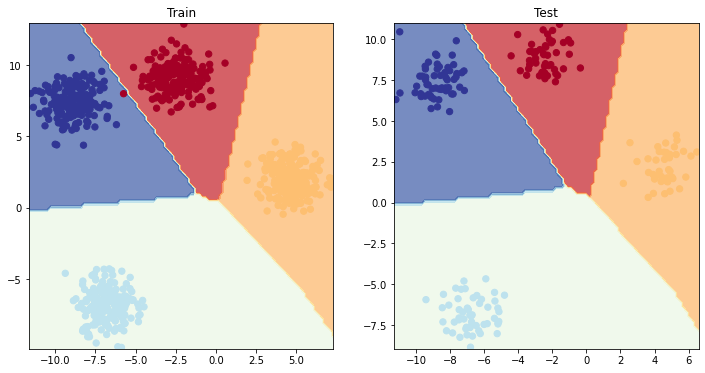

In [73]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [74]:
!pip -q install torchmetrics

from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy().to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

     |████████████████████████████████| 529 kB 38.4 MB/s 


tensor(1.)